# Spike Detection

この章では，実際のHD-MEAで取得された信号の一部を用いて，spike検出の一例を示す．  
使用するデータセットは，3×3の正方形状に隣接する9個の電極から取得された5分間の電位記録を圧縮したh5データである．サンプリング周波数は$f_s = 20 \mathrm{kHz}$である．電極の座標（$x, y$）[$\mathrm{\mu m}$]に関する情報は`mapping`に記録した．

h5データの取り扱いに関する詳細は，別の章で述べる．

In [198]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 200

In [199]:
datadir = '../datasets/04/'
fs = 20000

In [200]:
# read signal
with h5py.File(datadir + 'data.raw.h5', 'r') as f:
    sig = f['sig'][()]
    mapping = f['mapping'][()]
    
# read electrode mapping
df_map = pd.DataFrame(mapping)

n_channels, n_frames = sig.shape

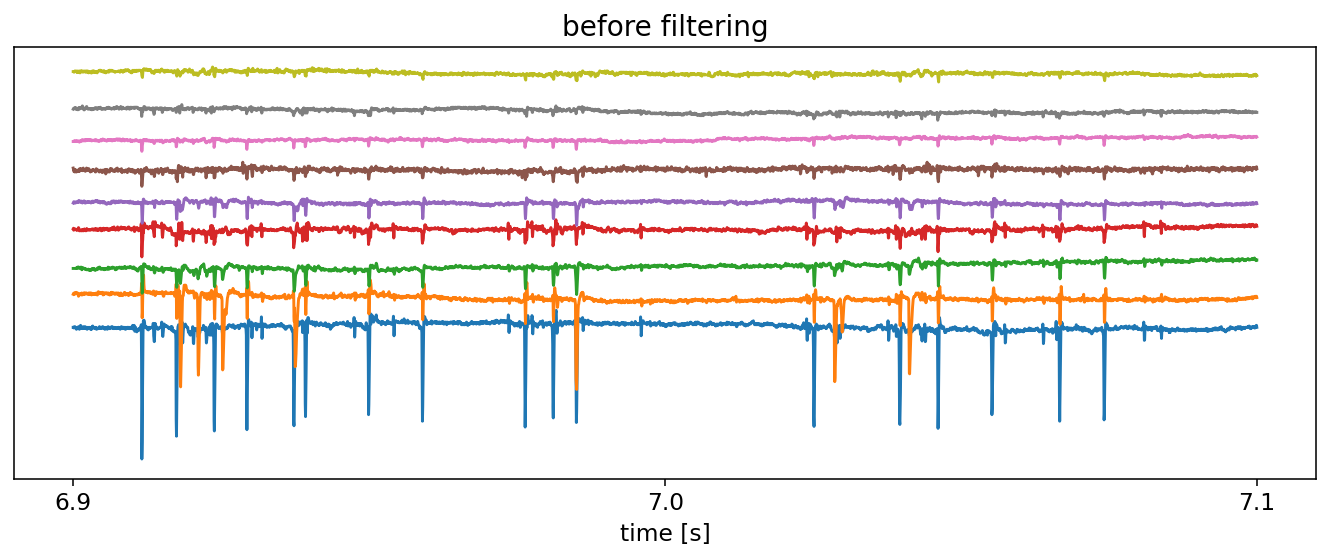

In [201]:
# time range
start_sec, end_sec = 6.9, 7.1
t = np.arange(start_sec * fs, end_sec * fs, 1).astype(int)

amps = np.max(sig, axis=1) - np.min(sig, axis=1)
offset = 300.0

# plotting
plt.figure(figsize=(12, 4))
plt.title('before filtering')

for i, j in enumerate(np.argsort(amps)[::-1]):
    plt.plot(t / fs, sig[j, t] + i * offset)

plt.yticks([])
plt.xlabel('time [s]')
plt.locator_params(axis='x', nbins=4)
plt.show()

## Band-pass Filtering

フィルタ前の生信号には，活動電位（spike）にとってあまり本質的ではない低周波，および高周波の成分が多く含まれている．  
活動電位は大まかに1msのオーダーの現象であるため，一般には数百〜数千の帯域幅でバンドパスフィルタをかけることにより，spikeに関する情報を扱いやすくする前処理を施す．

In [202]:
from scipy.signal import butter, filtfilt, lfilter

In [203]:
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(sig, lowcut, highcut, fs, order=3):    
    if sig.ndim == 1:
        sig = np.atleast_2d(sig)
        
    sig = (sig - np.mean(sig, axis=1).reshape(-1, 1))  # offset with average
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, sig)  # zero-phase filter

In [204]:
sig_filt = bandpass_filter(sig, lowcut=300, highcut=5000, fs=fs)

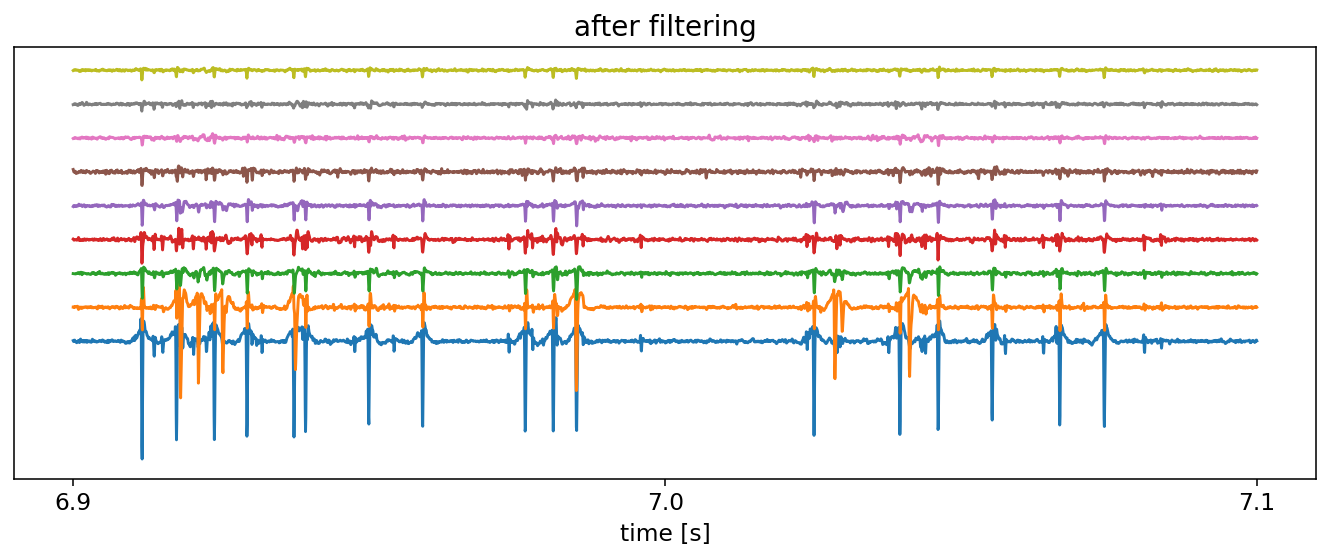

In [205]:
# time range
start_sec, end_sec = 6.9, 7.1
t = np.arange(start_sec * fs, end_sec * fs, 1).astype(int)

amps = np.max(sig_filt, axis=1) - np.min(sig_filt, axis=1)
offset = 300.0

# plotting
plt.figure(figsize=(12, 4))
plt.title('after filtering')

for i, j in enumerate(np.argsort(amps)[::-1]):
    plt.plot(t / fs, sig_filt[j, t] + i * offset)

plt.yticks([])
plt.xlabel('time [s]')
plt.locator_params(axis='x', nbins=4)
plt.show()

これらの信号が観測された電極群は互いに隣接しているため，活動電位の信号が電極間で相関していることが見て取れる．  
電極のマッピングと共に信号をプロットすると以下のようになる．

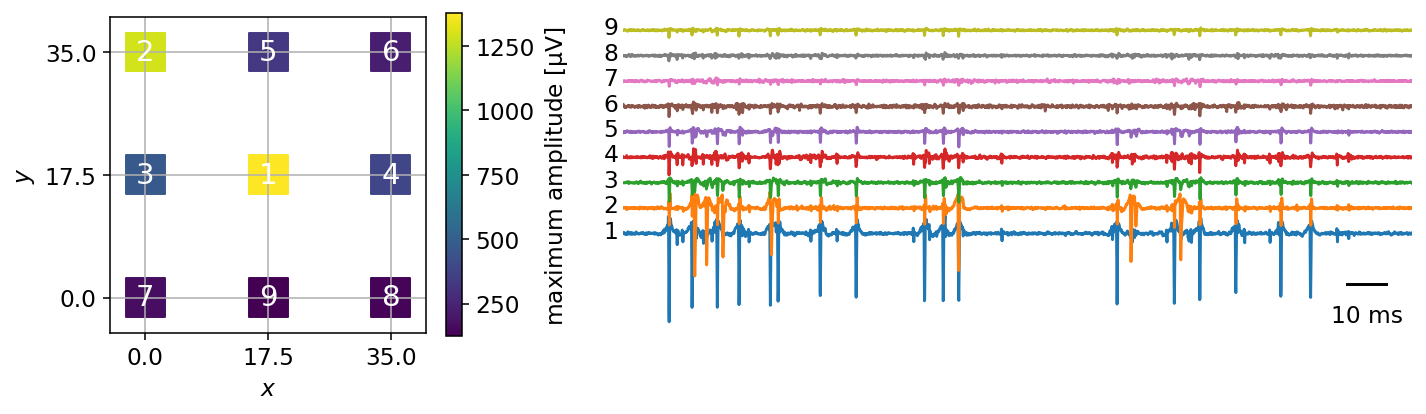

In [206]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3), gridspec_kw={'width_ratios': [2.0, 4.0]})

# mapping plot
ax = axes[0]
sc = ax.scatter(df_map.x, df_map.y, marker='s', s=400, c=amps)
df_map['amplitude'] = amps

for i, (index, row) in enumerate(df_map.sort_values('amplitude', ascending=False).iterrows()):
    ax.annotate(text=str(i+1), xy=(row.x, row.y), fontsize=15, color='w', ha='center', va='center')

ax.grid()
ax.set_aspect('equal')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_xlim(df_map.x.min() - 5, df_map.x.max() + 5)
ax.set_ylim(df_map.y.min() - 5, df_map.y.max() + 5)
ax.set_xticks(list(set(df_map.x)))
ax.set_yticks(list(set(df_map.y)))
cbar = fig.colorbar(mappable=sc, ax=ax, label=r'maximum amplitude [$\mathrm{\mu V}$]')

# signals plot
ax = axes[1]
for i, j in enumerate(np.argsort(amps)[::-1]):
    ax.plot(t / fs, sig_filt[j, t] + i * offset)
    ax.text(t[0] / fs - 0.005, i * offset - 50, s=str(i + 1), fontdict={'fontsize': 12})

# remove axis and add scalebar instead
scalebar = AnchoredSizeBar(ax.transData, 0.01, '10 ms', 'lower right', pad=0.1, borderpad=0.3, sep=10, color='black', frameon=False, size_vertical=5)
ax.add_artist(scalebar)
ax.set_axis_off()
ax.set_xlim(t[0] / fs, t[-1] / fs)

plt.show()

```{note}
上の例ではゼロ位相フィルタである`filtfilt`関数を採用している．フィルタをかけると元の信号と比較して遅延が生じる．ゼロ位相フィルタは，信号の順方向および逆方向の両方で処理することにより位相遅れの問題を解消する．ただし，spike立ち上がり時の信号がspike発生時刻の後ろだけではなく前にもはみ出すため，spike発生前の信号を元にした識別モデルを作成するケースなどにおいて注意が必要である．
```

以下に，フィルタによるスパイク波形の歪みを比較する．

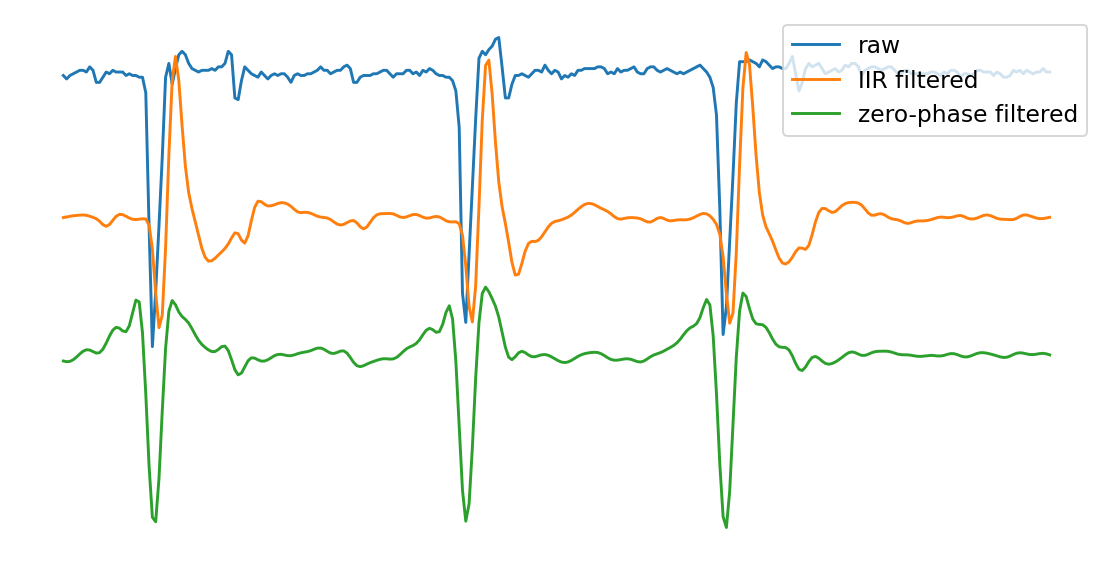

In [207]:
start_sec, end_sec = 6.975, 6.990
t = np.arange(start_sec * fs, end_sec * fs, 1).astype(int)

s = sig[3, t]
s -= np.mean(s)

b, a = butter_bandpass(500, 3000, fs, 3)  # shorter band-range

s_lfilt = lfilter(b, a, s)  # IIR filter
s_filtfilt = filtfilt(b, a, s)  # zero-phase filter

plt.figure(figsize=(10, 5))
plt.plot(t / fs, s, label='raw')
plt.plot(t / fs, s_lfilt - 500, label='IIR filtered')
plt.plot(t / fs, s_filtfilt - 1000, label='zero-phase filtered')

plt.axis('off')
plt.legend(loc='upper right')
plt.show()

通常のIIRフィルタではspike検出点である負のピークに遅延があることが分かる．また，ゼロ位相フィルタでは負のピークの位置が保たれているものの，活動電位の発生前から電位の立ち上がりが出現し，ピークの形状が対称に近くなっていることが見てとれる．

## Peak Detection

MEAは細胞外電位を計測するため，細胞内の電位が正に転じる活動電位は，細胞外の電極では負に反転して計測される．ある閾値を超えた負のピークを活動電位とみなす手法が最も用いられる．  
閾値は信号をみて肉眼で設定することも可能だが，スケール性を考えると自動化することが望まれる．電極によりSN比が異なるため，ノイズの大きさとの兼ね合いで最適な閾値を考える必要がある．

絶対中央偏差（median absolute deviation; MAD）はデータのバラつきを評価する指標の一つであり，次のように定義される．

$$
\mathrm{MAD} = \mathrm{median}(|X_i - \mathrm{median}(X)|)
$$

標準偏差と比較して，MADは外れ値に対してロバストである．

スパイク検出の閾値$\theta$は，$\mathrm{MAD}$の定数倍を用いる．定数$\lambda$は計測系のノイズレベルや，細胞の特性に応じて設定する．

$$
\theta = \lambda \cdot \mathrm{MAD}
$$

閾値法以外のspike検出手法として，神経細胞の活動電位波形が既知の場合（cf. spike-sorting）にテンプレートマッチングを用いて検出する手法 {cite}`Laboy-Juarez2019` や，機械学習モデルによりspikeとしてもっともらしい波形を評価する手法 {cite}`Lee2020` がある．

In [211]:
from scipy import stats
from scipy.signal import find_peaks

In [243]:
def peak_detection(sig, thr, distance=50):
    peaks, _ = find_peaks(-1 * sig, height=thr, distance=distance)
    return peaks

def thr_mad(sig, n=7):
    return stats.median_abs_deviation(sig) * n

`scipy`の`find_peaks`関数では閾値以外にいくつかのパラメタがあり，特に`distance`は検出するspike間隔の最小値を決める重要なパラメタである．  
以下に，2種類の`distance`によるスパイク検出の結果を比較する．

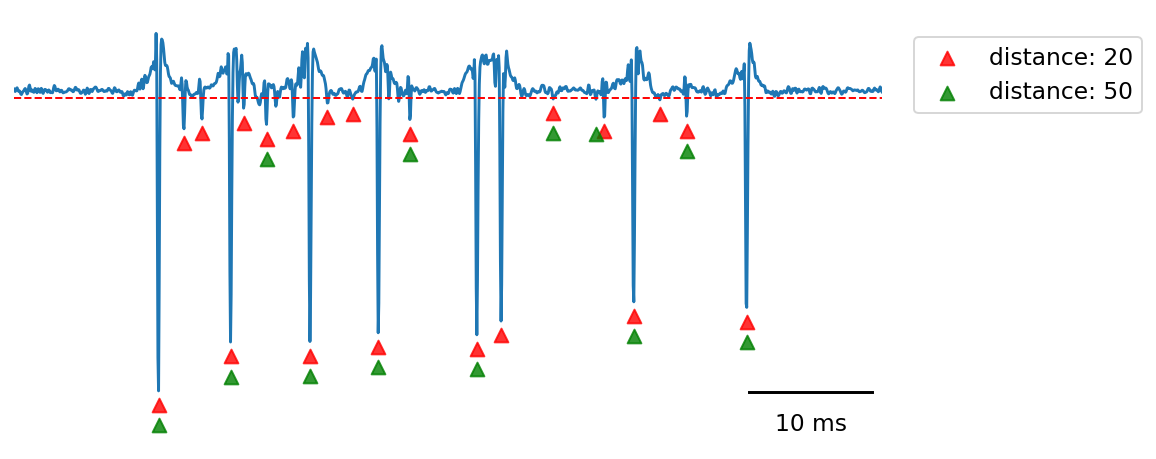

In [289]:
# use electrode with maximum amplitude
s = sig_filt[np.argmax(amps)]
thr = thr_mad(s)

# range for spike detection
start_sec, end_sec = 6.90, 6.97
t = np.arange(start_sec * fs, end_sec * fs, 1).astype(int)

# plotting
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(t / fs, s[t])
ax.axhline(y=-thr, xmin=0.0, xmax=1.0, color='red', linestyle='dashed', linewidth=1.0)

ymin, ymax = ax.get_ylim()

# distance = 20
peaks = peak_detection(sig=s[t], thr=thr, distance=20)
ax.scatter(t[peaks] / fs, s[t[peaks]] - 50, s=50, alpha=0.8, marker='^', c='red', label='distance: 20')

# distance = 50
peaks = peak_detection(sig=s[t], thr=thr, distance=50)
ax.scatter(t[peaks] / fs, s[t[peaks]] - 120, s=50, alpha=0.8, marker='^', c='green', label='distance: 50')

scalebar = AnchoredSizeBar(ax.transData, 0.01, '10 ms', 'lower right', pad=0.1, borderpad=0.3, sep=10, color='black', frameon=False, size_vertical=5)
ax.add_artist(scalebar)

ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=1, fontsize=12)
ax.set_xlim(t[0] / fs, t[-1] / fs)
ax.axis('off')

plt.show()

spike検出で注意すべきこととして，フィルタの影響により，活動電位による負のピークの後，ベースラインに戻る際に再び負方向への沈み込みが出現する．これがピークとして重複検出されることがあるため，`distance`の設定を工夫して誤検出を減らすか，後述するspike-sortingの手法により，偽陽性（false-positive）によるノイズを除去する必要がある．

上図で比較すると，`distance: 50`の場合は`distance: 20`と比較して偽陽性（ノイズをspikeとして誤検出するケース）が少ないが，一方で偽陰性（spikeを取りこぼすケース）が増加する．解析の目的に応じて調整するのが良いと考えられる．

実際にscriptとしてspike検出を全電極について行う際は，例えば次のようにpeakとchannelの列を格納していく方法がある．

In [288]:
spiketimes = []
channels = []

for i in range(n_channels):
    s = sig_filt[i]
    peaks = peak_detection(sig=s, thr=thr_mad(s), distance=20)
    spiketimes.extend(peaks / fs)
    channels.extend([i] * len(peaks))

df_sp = pd.DataFrame({'spiketime': spiketimes, 'channel': channels})
display(df_sp.head())

,spiketime,channel
0,1.42215,0
1,1.42490,0
2,1.42705,0
3,1.42935,0
4,1.43070,0


以下に，ラスタープロットと各電極の信号を合わせて表示する．隣接する電極であるため，信号は強く相関し，同じ神経細胞の信号が複数の電極にまたがって観測されることがわかる．次章では同じデータを使用して，混在する複数の細胞の信号を単一の細胞ごとに分離する統計処理であるspike-sortingについて述べる．

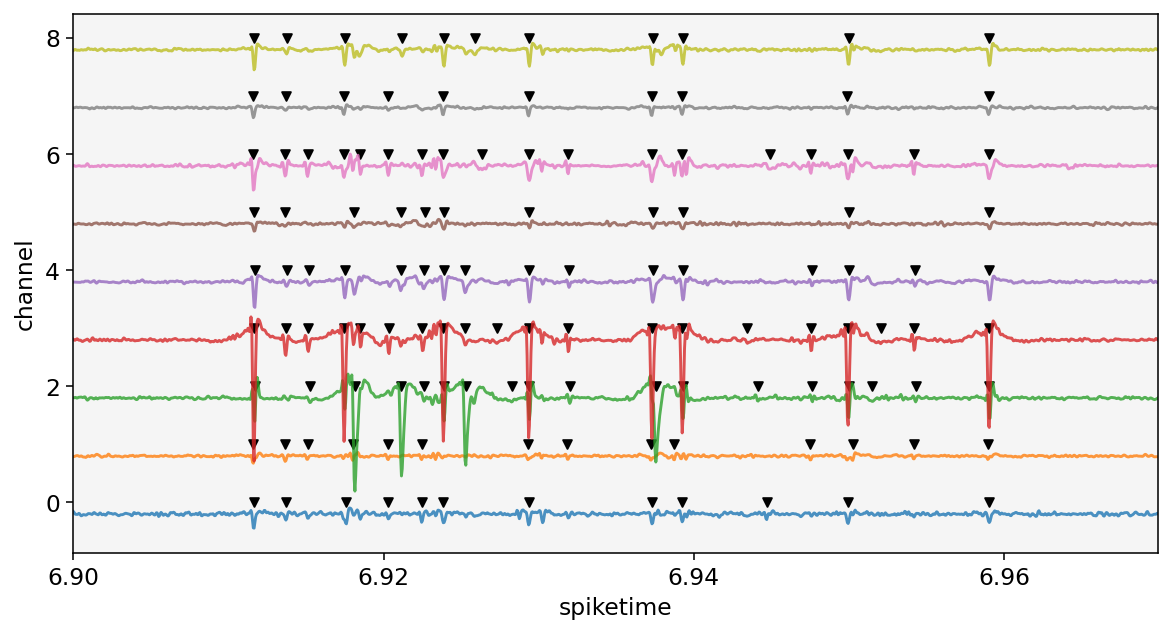

In [286]:
fig, ax = plt.subplots(figsize=(10, 5))

start_sec, end_sec = 6.90, 6.97
t = np.arange(start_sec * fs, end_sec * fs, 1).astype(int)

for i in range(n_channels):
    s = sig_filt[i]
    ax.plot(t / fs, (i - 0.2) + (s[t] / 500), alpha=0.8)
    
df_sp.query(f'{start_sec} < spiketime < {end_sec}').plot.scatter(ax=ax, x='spiketime', y='channel', c='k', s=20, marker='v')

ax.set_xlim(t[0] / fs, t[-1] / fs)
ax.set_facecolor('whitesmoke')

plt.locator_params(axis='x', nbins=4)
plt.show()

---
```{bibliography}
:filter: docname in docnames
```